# PyTorch model

Dates so far: 
* December 2022 20-22 (6 dates) in data_L2
* June 2022 8-12 (6 dates) in data_L2
* February 2023 10-12 (6 dates) in data_L2
* Febuary 2022 20-25 (7 dates) in data_L2
* May 2022 1-5 (6 dates) in data_L2

Total: 30 dates, so $30\times610\times190$ pixels, with 17 spectral lines each 

Data augmentation: gains (brigher or darker) -- spectral augmentation, shifting (red or blue), adding noise (photon or cosmic rays spikes)

Pytorch lightning / Jacks (google)

Implement data loader that can return any of the spectra in any of the dates and will return the spectrum augmented (original and a version of the spectrum with random offset and random gain random photon noise and random spikes of GCR

In [1]:
import os
import torch
import sys
from torch import nn
# import lightning as L
import pandas as pd
import xarray as xr
import csv
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from brokenaxes import brokenaxes
import warnings 
import tqdm
warnings.filterwarnings("ignore")

In [3]:
from simspice.data.SproutDataset import SproutDataset
from torch.utils.data import DataLoader
from simspice.utils.Augmentation import Augmentation
from simspice.data.Sprout_ML import Sprout_ML, interpolate_arrays

In [4]:
import wandb

In [5]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.device(0))
torch.cuda.get_device_name(0)

True
4


'NVIDIA A100 80GB PCIe'

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 


# Test zone
----------------------------------------------------------------------------------------------

In [8]:
directory_path = '/d0/tvaresano/SimSPICE/data_L2/'
sprout = Sprout_ML(directory_path, 'solo_L2_spice-n-ras_20220220T125345_V22_100663594-000.fits')

In [9]:
wvlarrays = sprout.get_wvl_arrays_A()
cubes = sprout.get_cubes()
keys = sprout.get_keys()

In [10]:
flux_arrays_padded, masks = sprout.pad_flux_array(method='zeros')
wvl_arrays_padded = sprout.pad_wvl_arrays()
print(flux_arrays_padded[0].shape, masks[0].shape)

(60, 605, 192) (60, 605, 192)


In [ ]:
wvl_all = np.hstack(wvl_arrays_padded)
mask_all = np.vstack(masks)
cubes_all = np.vstack(flux_arrays_padded)
print('Full wavelength array shape: ', wvl_all.shape, '\nFull spectrum shape : ', cubes_all.shape, '\nFull mask shape : ', mask_all.shape)

### Plot mask, full specrta, and noised full spectra

In [25]:
all_spectra = xr.open_dataset("/d0/tvaresano/SimSPICE/spectra_train_NeMg.nc")
item = all_spectra.isel(index=3075)
item1 = all_spectra.isel(index=1000)

In [53]:
def add_photon_noise(spectrum): 
    if isinstance(spectrum, np.ndarray):
        spectrum[spectrum < 0] = 0
        return spectrum+np.random.poisson(np.nan_to_num(spectrum))/(8*1/(np.median(item1['flux'].values)))
    else:
        spectrum = spectrum['flux'].values
        spectrum[spectrum < 0] = 0
        return spectrum+np.random.poisson(np.nan_to_num(spectrum['flux'].values))/(8*(1/(np.median(item1['flux'].values))))

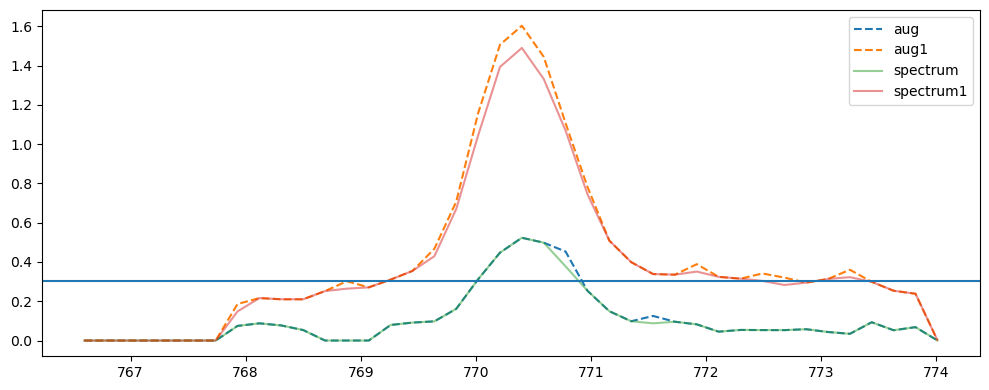

In [54]:
plt.figure(figsize=[10,4], tight_layout=True)
plt.plot(item['wvl'].values, add_photon_noise(item['flux'].values), label='aug', linestyle='--')
plt.plot(item['wvl'].values, add_photon_noise(item1['flux'].values), label='aug1', linestyle='--')
plt.plot(item['wvl'].values, item['flux'].values, label='spectrum', alpha=0.5)
plt.plot(item['wvl'].values, item1['flux'].values, label='spectrum1', alpha=0.5)
plt.axhline(np.median(item1['flux'].values))
plt.legend()

In [19]:
aug = Augmentation(type_distrib_gain='uniform')

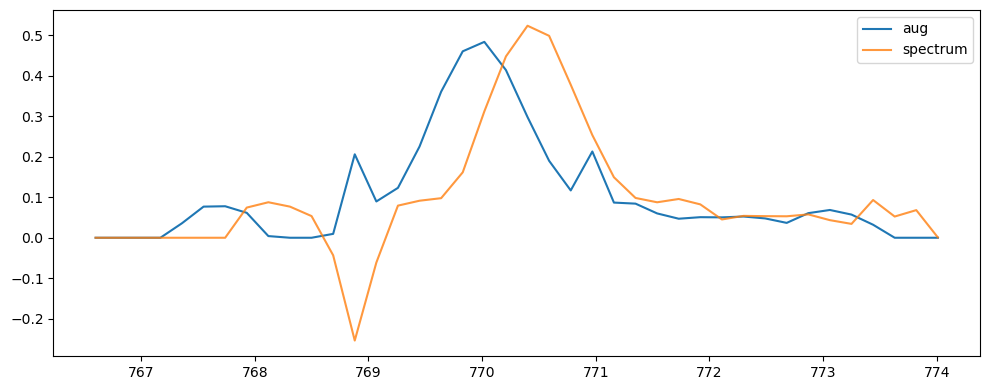

In [20]:
plt.figure(figsize=[10,4], tight_layout=True)
plt.plot(item['wvl'].values, aug.run_all_augmentations(item)[0], label='aug')
plt.plot(item['wvl'].values, item['flux'].values, label='spectrum', alpha=0.8)
plt.legend()

In [ ]:
plt.figure(figsize=[20,4])
plt.subplot(1,4,1)
plt.plot(wvl_arrays_padded[0], flux_arrays_padded[0][:,300,150]*10, label='spectrum')
plt.plot(wvl_arrays_padded[0], masks[0][:,300,150], label='mask')
plt.legend()
plt.title('O III / Mg IX at one pixel')
plt.subplot(1,4,2)
plt.plot(wvl_arrays_padded[0], aug.add_photon_noise(flux_arrays_padded[0][:,300,150]*10), label='spectrum')
plt.plot(wvl_arrays_padded[0], masks[0][:,300,150], label='mask')
plt.legend()
plt.title('O III / Mg IX at one pixel, photon noise')
plt.subplot(1,4,3)
plt.plot(wvl_arrays_padded[0], aug.add_GCR_noise(flux_arrays_padded[0][:,300,150]*10, hit_probability=0.02), label='spectrum')
plt.plot(wvl_arrays_padded[0], masks[0][:,300,150], label='mask')
plt.legend()
plt.title('O III / Mg IX at one pixel, GCR noise')

plt.subplot(1,4,4)
shifted_spectrum = aug.shift_spectrum(wvl_arrays_padded[0], flux_arrays_padded[0][:,300,150]*10, shift=1)  
plt.plot(wvl_arrays_padded[0], flux_arrays_padded[0][:,300,150]*10, label="Original")
plt.plot(wvl_arrays_padded[0], shifted_spectrum, label="Shifted (1 $\AA$)", linestyle='--')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.legend()
plt.title('O III / Mg IX at one pixel, shifted')

In [ ]:
plt.figure(figsize=[12,12], tight_layout=True)
plt.subplot(4,1,1)
plt.plot(item['wvl'].values, item['flux'].values*10, label='spectrum')
plt.plot(wvl_all, mask_all[:,300,150], label='mask')
plt.legend()
plt.title('Full spectrum at one pixel')
plt.subplot(4,1,2)
plt.plot(item['wvl'], aug.add_photon_noise(item['flux'].values*10), label='spectrum')
# plt.plot(wvl_all, masks[0][:,300,150], label='mask')
plt.legend()
plt.title('Full spectrum at one pixel, photon noise')
plt.subplot(4,1,3)
plt.plot(item['wvl'], aug.add_GCR_noise(item)*10, label='spectrum')
plt.legend()
plt.title('Full spectrum at one pixel, GCR noise')

plt.subplot(4,1,4)
shifted_spectrum = aug.add_shift_spectrum(item)  
plt.plot(item['wvl'], item['flux'].values*10, label="Original")
plt.plot(item['wvl'], shifted_spectrum[0]*10, label="Shifted (1 $\AA$)", linestyle='--')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.legend()
plt.title('Full spectrum at one pixel, shifted')
plt.suptitle('Data visualization and augmentation\n', fontsize=15)

----------------------------------------------------------------------------------------------
# End of the test zone

### Write all spectral info in a .csv file

In [ ]:
def write_spectra_charac_to_csv(directory, csv_file):

    with open(csv_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Filename', 'Spectral size 1', 'Spectral size 2', 'Spectral size 3', 'Spectral size 4', 'Spectral size 5', 'Spectral size 6', 
                            'Spectral size 7', 'Spectral size 8', 'Spectral range 1', 'Spectral range 2', 'Spectral range 3','Spectral range 4', 
                            'Spectral range 5', 'Spectral range 6', 'Spectral range 7', 'Spectral range 8'])  

        for filename in os.listdir(directory):
            if os.path.isfile(os.path.join(directory, filename)):
                file = Sprout_ML(directory, filename)
                rasters = file.get_cubes()     # Get a list of all the rasters
                wavelength_arrays = file.get_wvl_arrays_A()
                spectral_sizes = []
                ranges = []
                for r, w in zip(rasters, wavelength_arrays):
                    spectral_size = r.shape[0] 
                    spectral_sizes.append(spectral_size)
                    range = (w[0], w[-1])
                    ranges.append(f"{range[0]}-{range[1]}")
                # padding with empty strings if fewer than 8
                # spectral_sizes = spectral_sizes[:8] + [''] * (8 - len(spectral_sizes))
                
                writer.writerow([filename] + spectral_sizes + ranges ) 


# if __name__ == '__main__': ## Execute when file runs as a script, but not when imported as a module
directory_path = 'C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\data_L2\\'  
csv_file_path = 'C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_dimensions.csv' 

#write_spectra_charac_to_csv(directory_path, csv_file_path)

### Write all spectra in a .csv file

In [ ]:
# def write_files_to_csv(directory, csv_file):

#     with open(csv_file, 'w', newline='') as f:
#         writer = csv.writer(f)
#         writer.writerow(['index', 'flux', 'mask', 'wvl'])  
#         i=0
#         for filename in os.listdir(directory):
#             if os.path.isfile(os.path.join(directory, filename)):
#                 file = Sprout_ML(directory, filename)
#                 padded_spectra, masks =  file.pad_flux_array(method='zeros') # get the padded flux arrays and corresponding masks
#                 wvl_arrays_padded = file.pad_wvl_arrays() # get the padded wavelengths arrays

#                 # transform the list of cubes to a single cube
#                 full_spectra = np.vstack(padded_spectra) 
#                 full_wvl = np.hstack(wvl_arrays_padded)
#                 full_mask = np.vstack(masks)
#                 for k in range(full_spectra.shape[1]):
#                     for l in range(full_spectra.shape[2]):    
#                         writer.writerow([str(i)+str(full_spectra[:,k,l])+str(full_wvl)+str(full_mask[:,k,l])]) 
#                         i+=1

# directory_path = '/d0/tvaresano/SimSPICE/\\data_L2\\'  
# csv_file_path = 'C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train.csv' 

# #write_files_to_csv(directory_path, csv_file_path)

### Write to netcdf format 

In [5]:
def write_files_to_netcdf(directory, netcdf_file, nbr_files=None):
    all_flux = []
    all_mask = []
    all_k = []
    all_l = []
    index = []
    filenames = []
    
    i = 0
    for filename in tqdm.tqdm(os.listdir(directory)[:nbr_files]):
        if os.path.isfile(os.path.join(directory, filename)):
            file = Sprout_ML(directory, filename)
            wvl_common = file.common_wvl
            
            #################################
            padded_spectra, masks = file.pad_flux_array(method='zeros')  # get padded flux arrays and masks
            wvl_arrays_padded = file.pad_wvl_arrays()
            full_spectra = np.vstack(padded_spectra)  # combine spectra into a single array
            full_mask = np.vstack(masks)  # combine masks
            full_wvl = np.hstack(wvl_arrays_padded)

            for k in range(full_spectra.shape[1]):
                for l in range(full_spectra.shape[2]):
                    spec_common_wvl, mask_common_wvl = interpolate_arrays(wvl_common, full_wvl, full_spectra[:, k, l], full_mask[:, k, l])
                    all_flux.append(spec_common_wvl)
                    all_mask.append(mask_common_wvl)
                    all_k.append(k)
                    all_l.append(l)
                    index.append(i)
                    filenames.append(filename)
                    i += 1

    # xarray Dataset
    ds = xr.Dataset(
        {
            "flux": (("index", "wvl"), np.array(all_flux)),
            "mask": (("index", "wvl"), np.array(all_mask)),
            "x-index" : (("index"), all_k),
            "y-index" : (("index"), all_l),
            "filename" : (("index"), filenames),
        },
        coords={"index": index,
                "wvl" : wvl_common, # interp1d array set of wvl every single spectrum is going to be interpolated into.
                }
            )

    # Save to NetCDF
    ds.to_netcdf(netcdf_file)

directory_path = '/d0/tvaresano/SimSPICE/data_L2/'
netcdf_file_path = '/d0/tvaresano/SimSPICE/spectra_train.nc'

write_files_to_netcdf(directory_path, netcdf_file_path, 10)

100%|██████████| 10/10 [03:18<00:00, 19.89s/it]


In [ ]:
netcdf_file_path = 'C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\datasets_deepL\\spectra_Feb2023.nc'
directory_path = 'C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\data_L2\\Feb2023\\'
write_files_to_netcdf(directory_path, netcdf_file_path, 1)

# Define classes

Self supervised: Backbone + fine tuning

* `Dataset` stores the samples and their corresponding labels. Custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`
* `DataLoader` wraps iterable around Dataset to enable easy access to samples

* `__getitem__` function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

In [ ]:
import random

In [ ]:
dataset = SproutDataset(augmentation_type=None)
item = dataset.__getitem__(75)
## or item = dataset(75)
# print(dataset.__len__())

In [ ]:
item = dataset.all_spectra.isel(index=75)

In [ ]:
aug = Augmentation(type_distrib_gain='unirform')
res_all = aug.run_all_augmentations(item)

In [ ]:
for i in range(5):
    item_nbr = random.randint(0, len(dataset))
    item = dataset.__getitem__(item_nbr)
    res_all = aug.run_all_augmentations(item)
    res_all1 = aug.run_all_augmentations(item)
    res_all2 = aug.run_all_augmentations(item)
    
    # Define the x-axis ranges to keep
    x1_start, x1_end = 690, 800
    x2_start, x2_end = 950, max(item['wvl'].values)+10
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1]})
    fig.subplots_adjust(wspace=0.05)
    
    # Plot data on the first axis
    ax1.plot(item['wvl'].values, res_all[0], label='augmented', color='plum')
    ax1.plot(item['wvl'].values, res_all[1], label='augmented mask', color='plum', linestyle='--')
    # ax1.plot(item['wvl'].values, res_all1[0], label='augmented1')
    # ax1.plot(item['wvl'].values, res_all2[0], label='augmented2')
    ax1.plot(item['wvl'].values, item['flux'].values, label='original', color='k')
    ax1.plot(item['wvl'].values, item['mask'].values, label='original mask', color='k', linestyle='--')
    ax1.set_xlim(x1_start, x1_end)
    ax1.set_ylim(0,15)
    #ax1.set_yscale('log')
    
    # Plot data on the second axis
    ax2.plot(item['wvl'].values, res_all[0], label='augmented', color='plum')
    ax2.plot(item['wvl'].values, res_all[1], label='augmented mask', color='plum', linestyle='--')
    # ax2.plot(item['wvl'].values, res_all1[0], label='augmented1')
    # ax2.plot(item['wvl'].values, res_all2[0], label='augmented2')
    ax2.plot(item['wvl'].values, item['flux'].values, label='original', color='k')
    ax2.plot(item['wvl'].values, item['mask'].values, label='original mask', color='k', linestyle='--')
    ax2.set_xlim(x2_start, x2_end)
    ax2.set_ylim(0,15)
    #ax2.set_yscale('log')
    
    # Hide the broken x-axis ticks between plots
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    ax2.tick_params(labelleft=False)
    
    # Add diagonal lines to indicate the axis break
    d = .015
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (-d, +d), **kwargs)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    
    plt.legend()
    fig.suptitle(f'Augmentations for item # {item_nbr}')
    plt.show()

## Dataloader

In [ ]:
BATCH_SIZE = 32

In [ ]:
from torch.utils.data import DataLoader


dataset = SproutDataset()

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True  )


In [ ]:
# Call lighlty (but assumes an image but we have 1D signals)
# Check what architectures are popular for 1D data

In [ ]:
# Create / request academic account of weights and biases wandb